In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [ ]:
print('Tensorflow version: {}'.format(tf.__version__) )

Tensorflow version: 1.15.2


In [ ]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 127, done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (127/127), 591.89 KiB | 16.91 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
%cd /content/stylegan2

/content/stylegan2


In [ ]:
import pretrained_networks
network_pkl = '/content/drive/MyDrive/BTP-2/network-snapshot-018528.pkl'
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)


Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
import numpy as np
def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [ ]:
!pip install tqdm

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=15)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, .7)

0it [00:00, ?it/s]

[9590230 7812200 8518872 7528086 4861516 1215000 5167079 1210375 8206941
  514114 8975898  808027 5808975 9553715 5301632]


15it [00:10,  1.39it/s]


In [ ]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

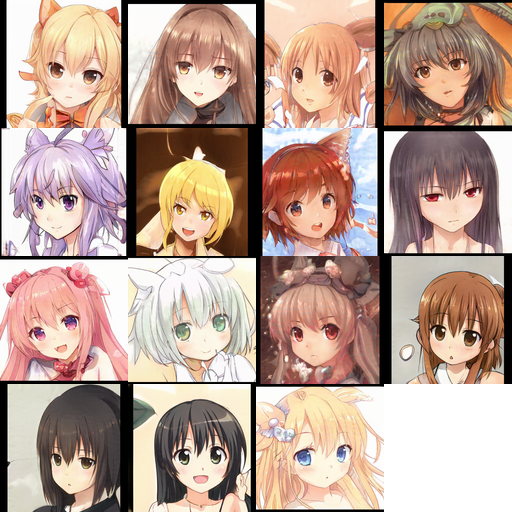

In [ ]:
createImageGrid(imgs, rows=4)

In [ ]:
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 20), 0.7)

20it [00:01, 13.20it/s]


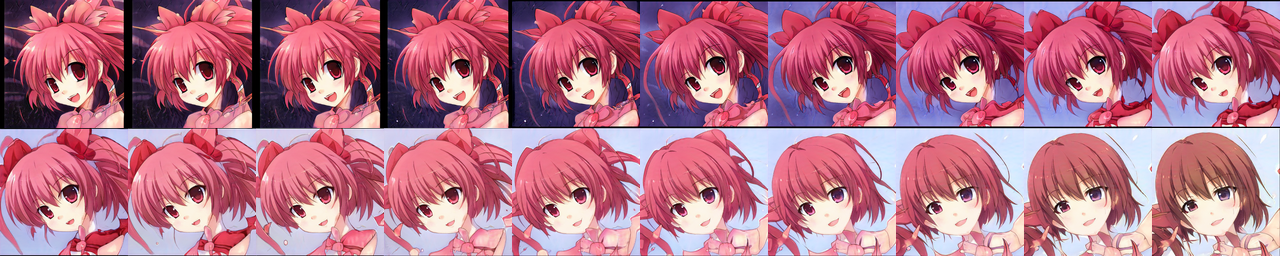

In [ ]:
createImageGrid(imgs, rows=2)

In [ ]:
import scipy

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=truncation_psi,
                          randomize_noise=False, output_transform=fmt, 
                          minibatch_size=16)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif(filename,fps=15)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1228800/45929032 bytes (2.7%)3670016/45929032 bytes (8.0%)7544832/45929032 bytes (16.4%)11550720/45929032 bytes (25.1%)15343616/45929032 bytes (33.4%)19169280/45929032 bytes (41.7%)23281664/45929032 bytes (50.7%)27320320/45929032 bytes (59.5%)31367168/45929032 bytes (68.3%)35528704/45929032 bytes (77.4%)39608320/45929032 bytes (86.2%)43433984/45929032 bytes (94.6%)4

 99%|█████████▊| 75/76 [01:15<00:01,  1.01s/it]


In [ ]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))


In [ ]:
show_video(filename)